In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [2]:
# Import libraries
import os
import numpy as np

from plantcv import plantcv as pcv 
from read_dataset import read_dataset

In [44]:
# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

# IMPORTANT: Create a directory to save the output labels and set the path in self.outdir

class options:
    def __init__(self):        
        self.image = ""
        self.debug = "plot"
        self.writeimg = False
        self.result = "segmentation"
        self.outdir = os.path.join(os.get_cwd(), "outputs")

In [4]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# set the output directory to the global parameter
pcv.params.debug_outdir = args.outdir

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

In [5]:
# Paths to the directories containing the rgb images and the binary masks
images_directory = './img/'
masks_directory =  './mask/'

# Create the lists of paths to the images and masks
# The read_dataset function is included in this repository, infuture versions it will 
# be included in the PlantCV package
images_paths_sort = read_dataset(source_path=images_directory, sort=True)
masks_paths_sort = read_dataset(source_path=masks_directory, sort=True)

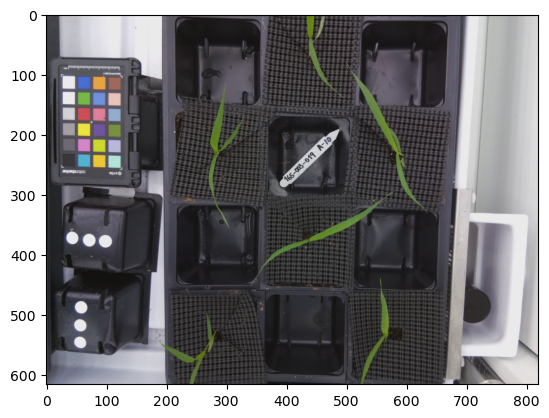

In [6]:
# Read the first image in the datased to be used as reference for the ROIs
i = 0
img0_path = images_paths_sort[i]
img0, _, _ = pcv.readimage(filename=img0_path)

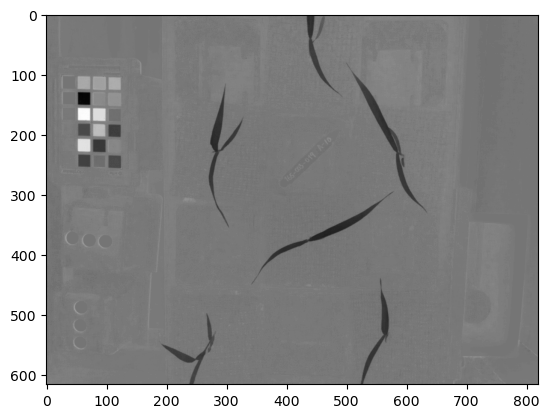

In [14]:
a = pcv.rgb2gray_lab(rgb_img=img0, channel='a')

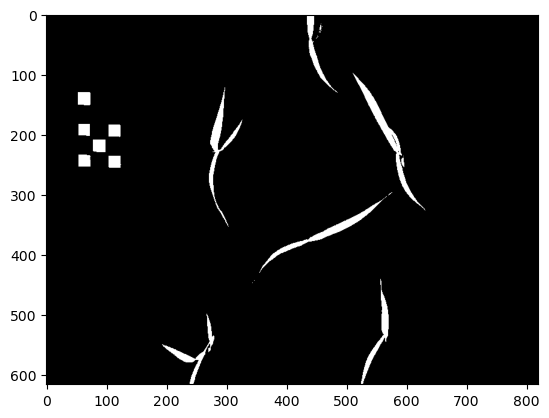

In [15]:
thresholded_image = pcv.threshold.otsu(gray_img=a, object_type='dark')

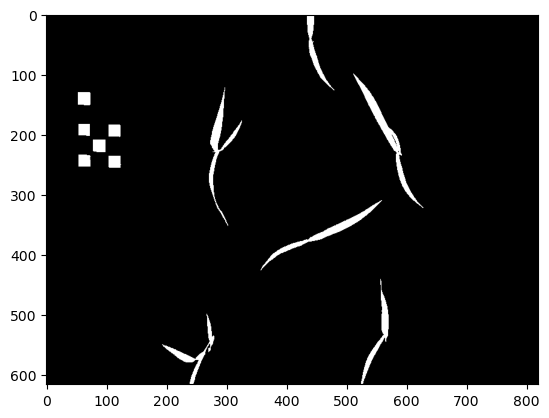

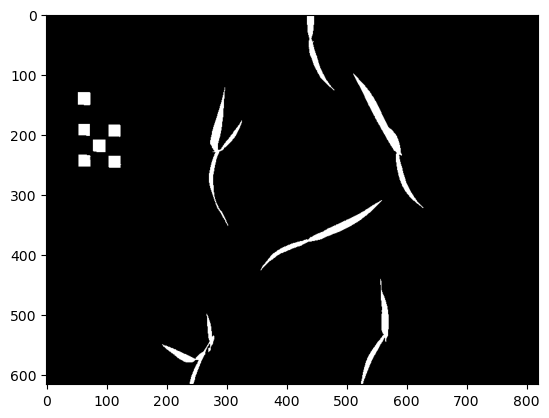

In [27]:
a_fill = pcv.fill(bin_img=thresholded_image, size=100)
a_fill = pcv.fill_holes(a_fill)

In [28]:
a_fill[:, :150] = 0

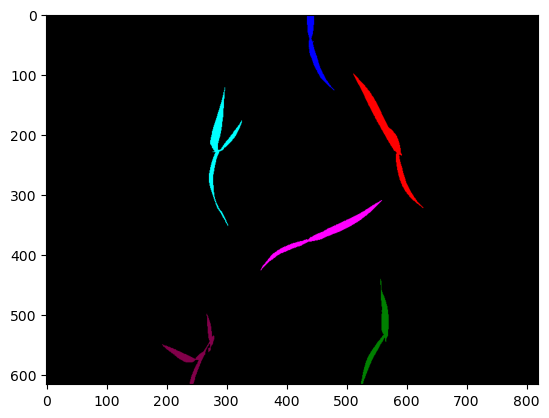

In [29]:
#Label the objects in your region of interest and number them
#Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask so that they are separate or it will treat them as a single object

#    mask            = the clean mask you made above after making your ROI

labeled_objects, n_obj = pcv.create_labels(mask=a_fill)

# This example has one color per leaf, so this would be good enough to do per-replicate trait extraction. 

In [30]:
print(np.unique(labeled_objects))

[0 1 2 3 4 5 6]


In [31]:
print(n_obj)

6


I'm using a rudimentary mean approximation to guess where I should put the rois at

In [33]:
import sys, os
#import cv2
def get_roi_centers(labeled_mask: np.ndarray, num_plants: int):

    #debugging stuff
    #print("image shape:")
    #print(img.shape)
    #print("mask shape:")
    #print(labeled_mask.shape)
    #print(img[:, 0, 0].shape)
    #print(img[0, :, 0].shape)
    #print(img[0, 0, :].shape)

    center_points = []
    for number in range(1, num_plants+1):
        # Create a mask for the current number
        mask = labeled_mask == number
        
        # Find indices where the mask is True
        cols, rows = np.nonzero(mask)
        
        if rows.size > 0 and cols.size > 0:
            # Calculate bounds
            #rows = y axis, columns = x axis, depth = z axis
            min_row, max_row = np.min(rows), np.max(rows)
            min_col, max_col = np.min(cols), np.max(cols)

            middle_row = (min_row + max_row) // 2
            middle_col = (min_col + max_col) // 2

            center_points.append((middle_row, middle_col))
        else:
            print(f"no indices for {number}")
            continue
    return center_points

#print(img.shape)
centers = get_roi_centers(labeled_objects, n_obj)

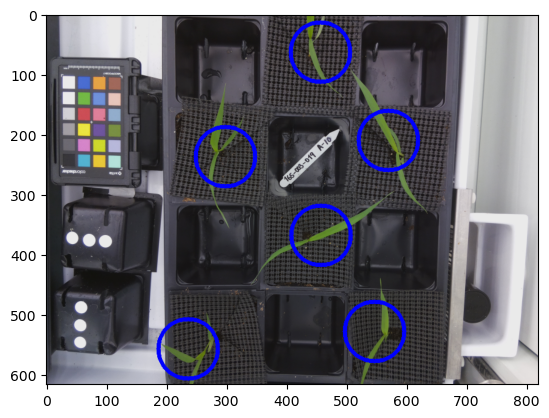

In [38]:
rois = pcv.roi.multi(img=img0, coord=centers, radius=50)

In [43]:
len(rois.contours)

6

In [46]:
# Run segment image series 
out = pcv.segment_image_series(images_paths_sort, masks_paths_sort, rois=rois.contours , save_labels=True, ksize=3)

In [50]:
lbl_mask, n_lbls = pcv.create_labels(mask=a_fill, rois=rois)

# Analyze the shape of each plant 
shape_img = pcv.analyze.size(img=img0, labeled_mask=lbl_mask, n_labels=n_lbls, label="plant")

# Print out a text file with shape data for each plant in the image 
pcv.outputs.save_results(filename=os.path.join("output_shapes", "test_output.txt"))

In [53]:
# Label the objects in your region of interest and number them
# Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask 
# so that they are separate or it will treat them as a single object


labeled_objects2, n_obj2 = pcv.create_labels(mask=a_fill, rois=rois, roi_type="partial")

In [55]:
analysis_image = pcv.analyze.size(img=img0, labeled_mask=labeled_objects2, n_labels=n_obj2)